# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
""
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import wrangle_zillow as wr
import preprocessing as pr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

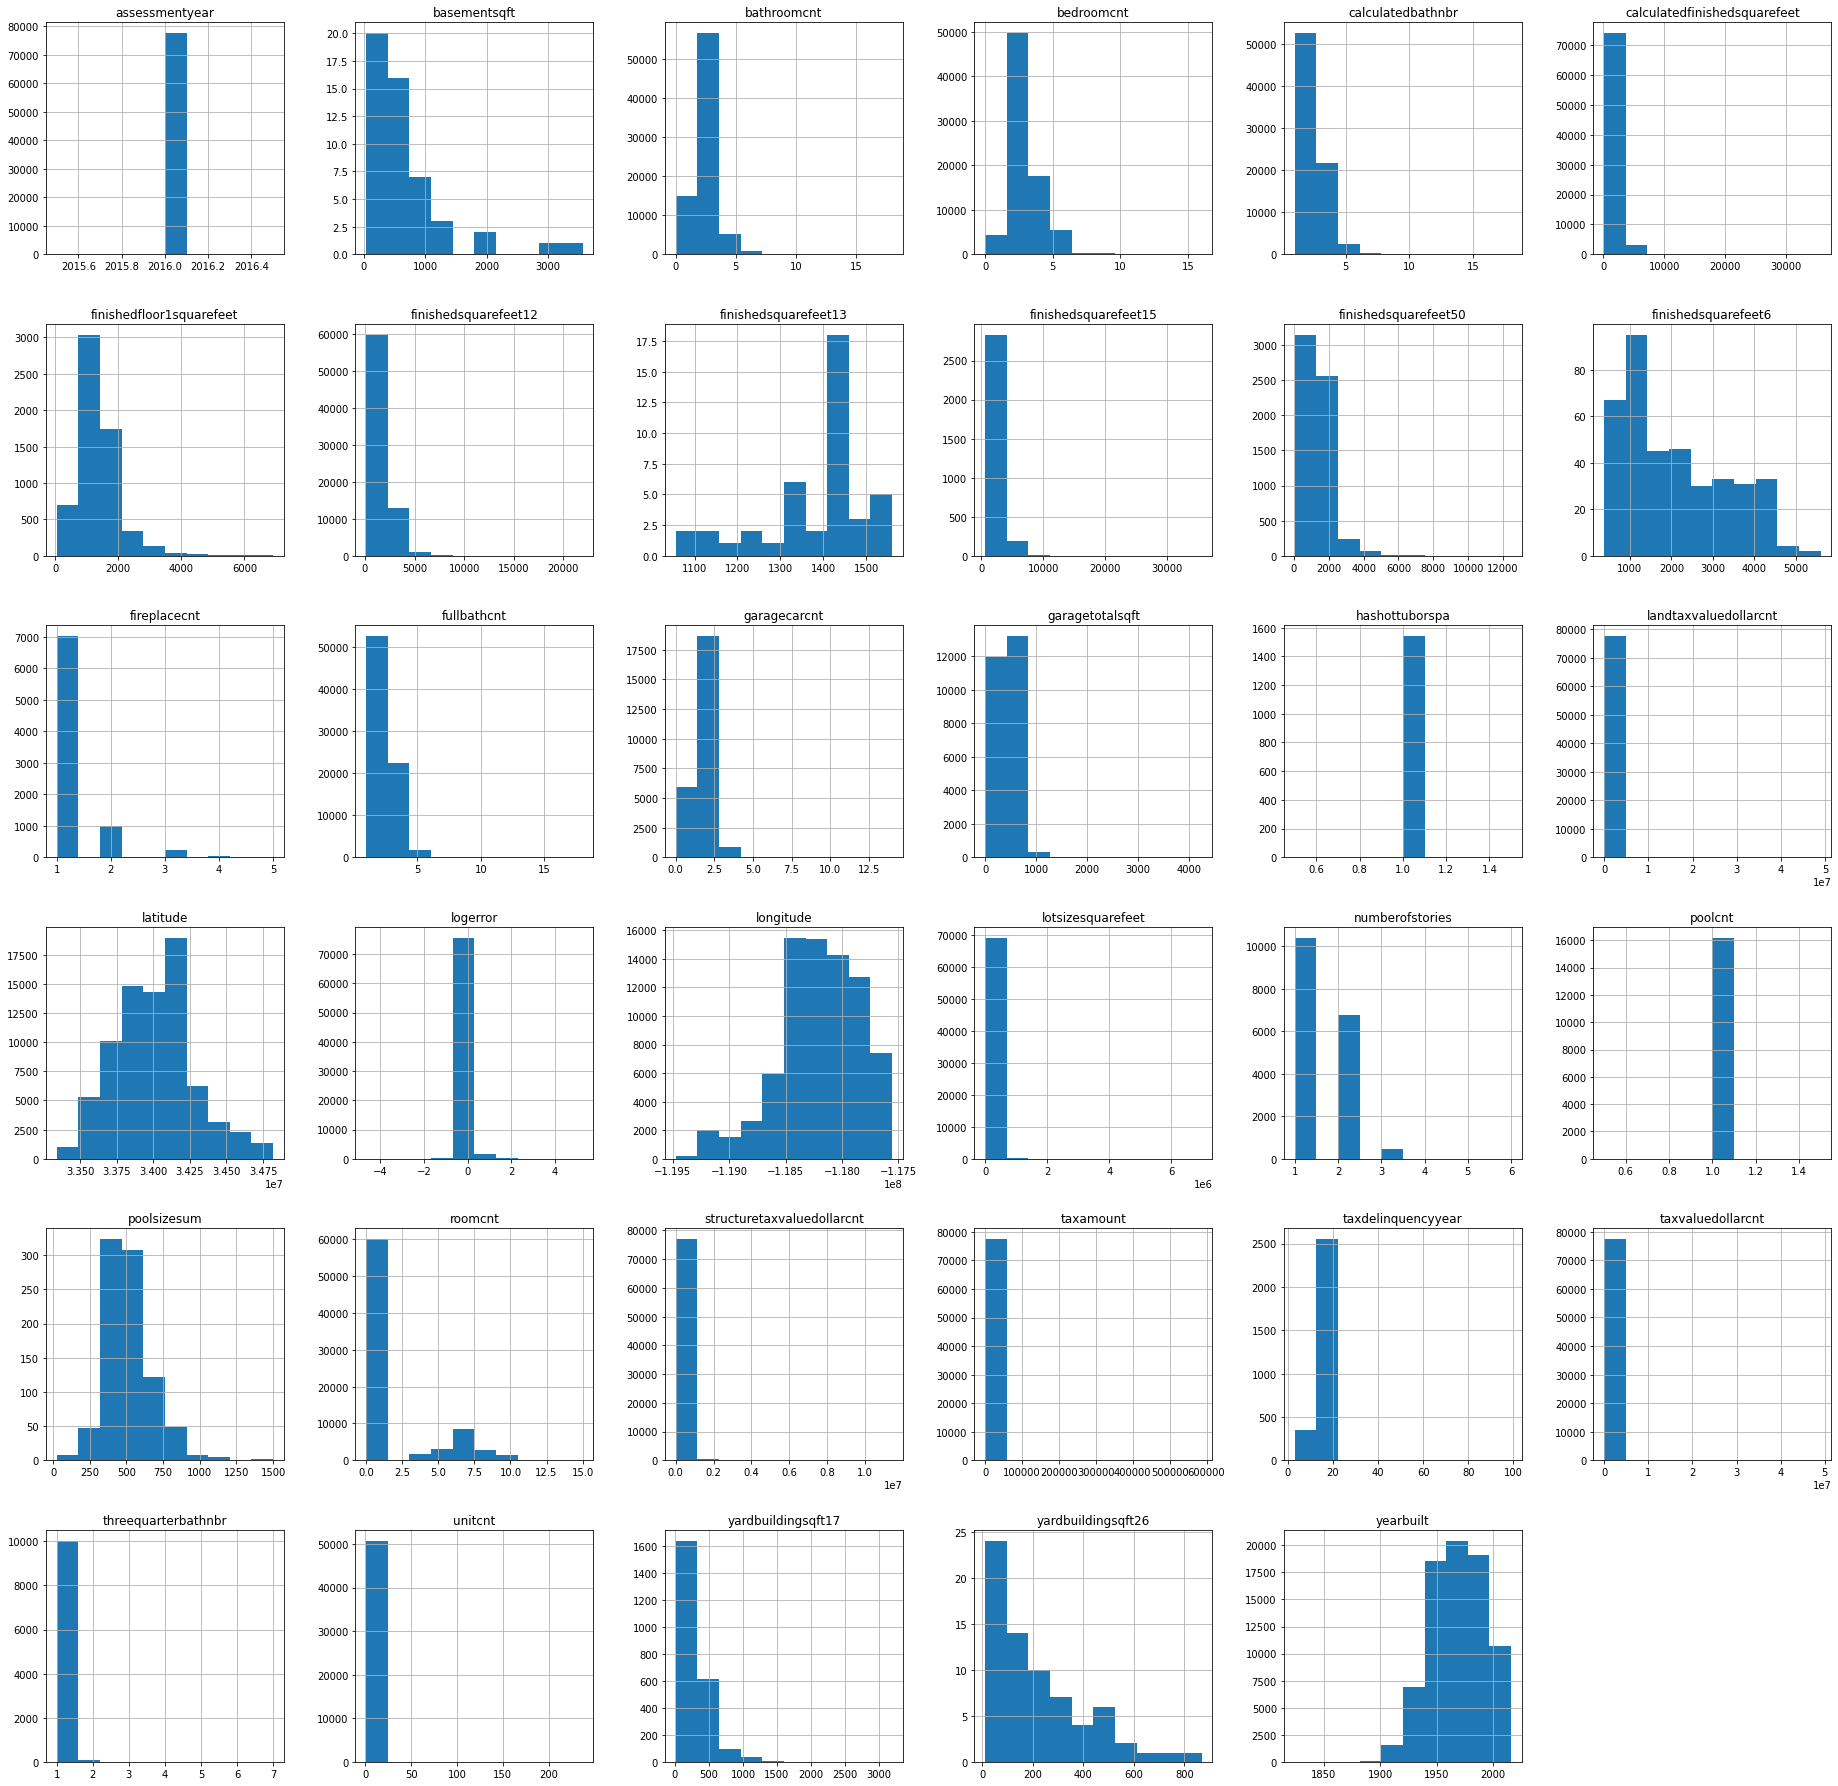

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

> **Now that we have a general idea of what our data looks like, let's move into preparation.**

---
# Prepare

In [6]:
# df = wr.get_single_unit_properties(df)
# df = wr.remove_columns(df, cols_to_remove=["id", "propertylandusetypeid", "heatingorsystemtypeid", "propertyzoningdesc", "finishedsquarefeet12"])
# df = wr.handle_missing_values(df)
# df = wr.impute_missing_values(df)
# df = wr.remove_rows(df, cols_to_mask=["structuretaxvaluedollarcnt", "taxamount", "censustractandblock", "regionidzip"])
# df = wr.create_new_variables(df)
# df.reset_index(inplace=True)
# df.drop(columns="index", inplace=True)
# df.info()

In [7]:
# df

In [8]:
# wr.convert_dtypes(df, columns=["fips", "regionidcity", "regionidcounty", "regionidzip"], dtype="object")
# df.hist(figsize=(16, 16))
# plt.show()

In [9]:
# df.tax_rate.sort_values(ascending=False).head(20)

In [10]:
# q1, q3 = df.tax_rate.quantile([.25, .75])
# q1, q3

In [11]:
# iqr = q3 - q1
# iqr

In [12]:
# upper_bound = q3 + (3 * iqr)
# upper_bound

In [13]:
# wr.get_upper_outliers(df.tax_rate, 3).sort_values(ascending=False).head(2149)

In [14]:
# df.loc[45416, :].tax_rate

In [15]:
# df.loc[16768, :].tax_rate

In [16]:
# more_than_three_times = lambda x: max([x - upper_bound, 0])
# more_than_three_times

In [17]:
# more_than_three_times(df.loc[45416, :].tax_rate).round(6)

In [18]:
# more_than_three_times(df.loc[16768, :].tax_rate)

In [19]:
# lower_bound = q1 - (3 * iqr)
# lower_bound

In [20]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values().head(66)

In [21]:
# df.loc[34753, :].tax_rate

In [22]:
# df.loc[5712, :].tax_rate

In [23]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values()[65]

In [24]:
# df.tax_rate.sort_values(ascending=False).tail(67)

In [25]:
# lower_bound

In [26]:
# min([df.loc[5712, :].tax_rate - lower_bound, 0])

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county` and `tax_rate` variables
7. Resets the index of the DataFrame
8. Drops former index column
9. Handles outliers

## Preprocessing
9. Splits prepared DataFrame into `train`, `validate`, and `test`
10. KNN imputes the regionidcity for `train`, `validate`, and `test`
11. Scales all appropriate numeric fields for `train`, `validate`, and `test`
12. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [27]:
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.0,-118706327.0,

In [28]:
df = wr.prep_zillow(df)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,roomcnt_upper_outliers,unitcnt_upper_outliers,yearbuilt_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,assessmentyear_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,bathroomcnt_lower_outliers,bedroomcnt_lower_outliers,calculatedbathnbr_lower_outliers,calculatedfinishedsquarefeet_lower_outliers,fullbathcnt_lower_outliers,lotsizesquarefeet_lower_outliers,roomcnt_lower_outliers,unitcnt_lower_outliers,yearbuilt_lower_outliers,structuretaxvaluedollarcnt_lower_outliers,taxvaluedollarcnt_lower_outliers,assessmentyear_lower_outliers,landtaxvaluedollarcnt_lower_outliers,taxamount_lower_outliers,tax_rate_lower_outliers,bathroomcnt_upper_outliers_lower_outliers,bedroomcnt_upper_outliers_lower_outliers,calculatedbathnbr_upper_outliers_lower_outliers,calculatedfinishedsquarefeet_upper_outliers_lower_outliers,fullbathcnt_upper_outliers_lower_outliers,lotsizesquarefeet_upper_outliers_lower_outliers,roomcnt_upper_outliers_lower_outliers,unitcnt_upper_outliers_lower_outliers,yearbuilt_upper_outliers_lower_outliers,structuretaxvaluedollarcnt_upper_outliers_lower_outliers,taxvaluedollarcnt_upper_outliers_lower_outliers,assessmentyear_upper_outliers_lower_outliers,landtaxvaluedollarcnt_upper_outliers_lower_outliers,taxamount_upper_outliers_lower_outliers,tax_rate_upper_outliers_lower_outliers
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,Orange County,0.010763,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,Ventura County,0.012225,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,Orange County,0.011488,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012247,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012306,0.0,0.0,0.0,0.0,0.

In [29]:
df.landtaxvaluedollarcnt_lower_outliers.value_counts()

0    52152
Name: landtaxvaluedollarcnt_lower_outliers, dtype: int64

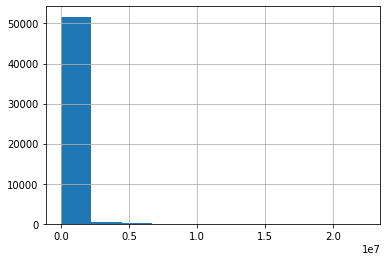

In [30]:
df.landtaxvaluedollarcnt.hist()

In [31]:
col_list = []
for col in df.columns:
    if col.endswith("_outliers"):
        if len(df[col].value_counts()) < 3:
            col_list.append(col)
df.drop(columns=col_list, inplace=True)

In [84]:
df.shape

(52152, 43)

In [85]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [86]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [87]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (31290, 43)
validate shape = (10431, 43)
    test shape = (10431, 43)


In [88]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,tax_rate_lower_outliers
20629,0.009697,0.000000,0.000000,0.272727,0.000000,0.039767,6037,0.000000,0.429497,0.640936,0.001013,0100,0.005844,396053,3101,95982,0.0,0.0,0.333333,0.001567,0.001077,0.0,0.000775,0.003098,0.000010,0.510391,2017-04-28,Floor/Wall,Single Family Residential,Los Angeles County,0.066047,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.027162,1.0
12740,0.024845,0.291667,0.333333,0.454545,0.291667,0.239289,6059,0.250000,0.198432,0.956228,0.000999,122,0.296733,12773,1286,96996,0.0,0.0,0.797101,0.070274,0.067845,0.0,0.052443,0.056687,0.000519,0.543068,2017-03-22,None,Single Family Residential,Orange County,0.020079,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0
33391,0.007067,0.000000,0.000000,0.454545,0.000000,0.026083,6037,0.000000,0.478220,0.638716,0.000827,010G,0.001437,12447,3101,95994,0.0,0.0,0.246377,0.007507,0.003399,0.0,0.000884,0.007662,0.000003,0.553112,2017-06-23,Central,Single Family Residential,Los Angeles County,0.053784,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014388,1.0
44811,0.004009,0.166667,0.333333,0.636364,0.166667,0.111035,6037,0.166667,0.889704,0.636147,0.001319,0100,0.010826,5534,3101,97319,0.0,0.0,0.956522,0.028482,0.013161,0.0,0.003240,0.027332,0.000019,0.569558,2017-08-15,Central,Single Family Residential,Los Angeles County,0.049981,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.010427,1.0
24405,0.022685,0.208333,0.333333,0.454545,0.208333,0.164853,6059,0.166667,0.379497,0.868787,0.001489,1,0.296595,21412,1286,97078,0.0,0.0,0.920290,0.082015,0.055777,0.0,0.031614,0.052995,0.000519,0.565937,2017-05-16,None,Single Family Residential,Orange County,0.022855,0.0,0.0,0.0,0.0,0.0,0.0,0.009632,0.0,0.0,0.0,0.000000,1.0


In [89]:
train.isna().sum()

parcelid                                       0
bathroomcnt                                    0
bedroomcnt                                     0
buildingqualitytypeid                          0
calculatedbathnbr                              0
calculatedfinishedsquarefeet                   0
fips                                           0
fullbathcnt                                    0
latitude                                       0
longitude                                      0
lotsizesquarefeet                              0
propertycountylandusecode                      0
rawcensustractandblock                         0
regionidcity                                   0
regionidcounty                                 0
regionidzip                                    0
roomcnt                                        0
unitcnt                                        0
yearbuilt                                      0
structuretaxvaluedollarcnt                     0
taxvaluedollarcnt   

In [90]:
validate.isna().sum()

parcelid                                       0
bathroomcnt                                    0
bedroomcnt                                     0
buildingqualitytypeid                          0
calculatedbathnbr                              0
calculatedfinishedsquarefeet                   0
fips                                           0
fullbathcnt                                    0
latitude                                       0
longitude                                      0
lotsizesquarefeet                              0
propertycountylandusecode                      0
rawcensustractandblock                         0
regionidcity                                   0
regionidcounty                                 0
regionidzip                                    0
roomcnt                                        0
unitcnt                                        0
yearbuilt                                      0
structuretaxvaluedollarcnt                     0
taxvaluedollarcnt   

In [91]:
test.isna().sum()

parcelid                                       0
bathroomcnt                                    0
bedroomcnt                                     0
buildingqualitytypeid                          0
calculatedbathnbr                              0
calculatedfinishedsquarefeet                   0
fips                                           0
fullbathcnt                                    0
latitude                                       0
longitude                                      0
lotsizesquarefeet                              0
propertycountylandusecode                      0
rawcensustractandblock                         0
regionidcity                                   0
regionidcounty                                 0
regionidzip                                    0
roomcnt                                        0
unitcnt                                        0
yearbuilt                                      0
structuretaxvaluedollarcnt                     0
taxvaluedollarcnt   

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31290 entries, 20629 to 33454
Data columns (total 43 columns):
parcelid                                       31290 non-null float64
bathroomcnt                                    31290 non-null float64
bedroomcnt                                     31290 non-null float64
buildingqualitytypeid                          31290 non-null float64
calculatedbathnbr                              31290 non-null float64
calculatedfinishedsquarefeet                   31290 non-null float64
fips                                           31290 non-null object
fullbathcnt                                    31290 non-null float64
latitude                                       31290 non-null float64
longitude                                      31290 non-null float64
lotsizesquarefeet                              31290 non-null float64
propertycountylandusecode                      31290 non-null object
rawcensustractandblock                         31

In [93]:
train.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,tax_rate_lower_outliers
count,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.0,31290.000000,31290.000000,31290.000000,31290.0,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000
mean,0.014721,0.108569,0.256468,0.470618,0.108558,0.081280,0.103212,0.461269,0.666993,0.001517,0.166482,0.127325,0.0,0.618606,0.021389,0.021631,0.0,0.017313,0.021954,0.000323,0.569802,0.026883,0.000972,0.000362,0.000972,0.001048,0.000863,0.000425,0.001973,0.002096,0.001748,0.002085,0.000673,0.999429
std,0.014930,0.084613,0.103100,0.125691,0.084597,0.046192,0.082676,0.185320,0.185535,0.010488,0.281780,0.210709,0.0,0.166672,0.028619,0.030653,0.0,0.028462,0.029746,0.005673,0.021990,0.012868,0.017444,0.014592,0.017444,0.015958,0.016938,0.010440,0.020183,0.022214,0.020752,0.021822,0.011616,0.019571
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005255,0.083333,0.222222,0.454545,0.083333,0.051247,0.083333,0.329418,0.559605,0.000769,0.004062,0.000000,0.0,0.521739,0.008424,0.007807,0.0,0.003900,0.008882,0.000007,0.564370,0.023378,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.012240,0.083333,0.222222,0.454545,0.083333,0.069339,0.083333,0.460621,0.688226,0.000942,0.007025,0.000000,0.0,0.594203,0.014362,0.015246,0.0,0.011328,0.015787,0.000012,0.568395,0.024776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.022394,0.166667,0.333333,0.545455,0.166667,0.098820,0.166667,0.572770,0.804376,0.001220,0.296872,0.333333,0.0,0.731884,0.024550,0.025124,0.0,0.021096,0.024963,0.000519,0.572687,0.027525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


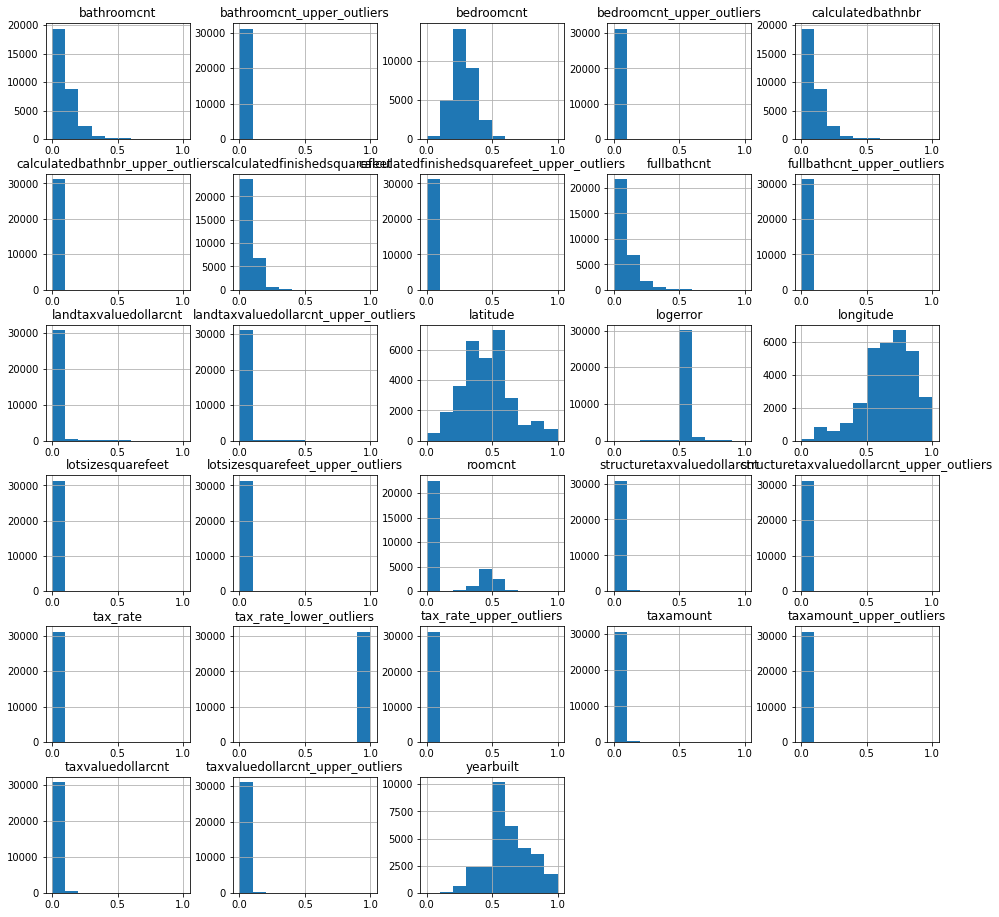

In [94]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

In [95]:
# sns.pairplot(data=train)

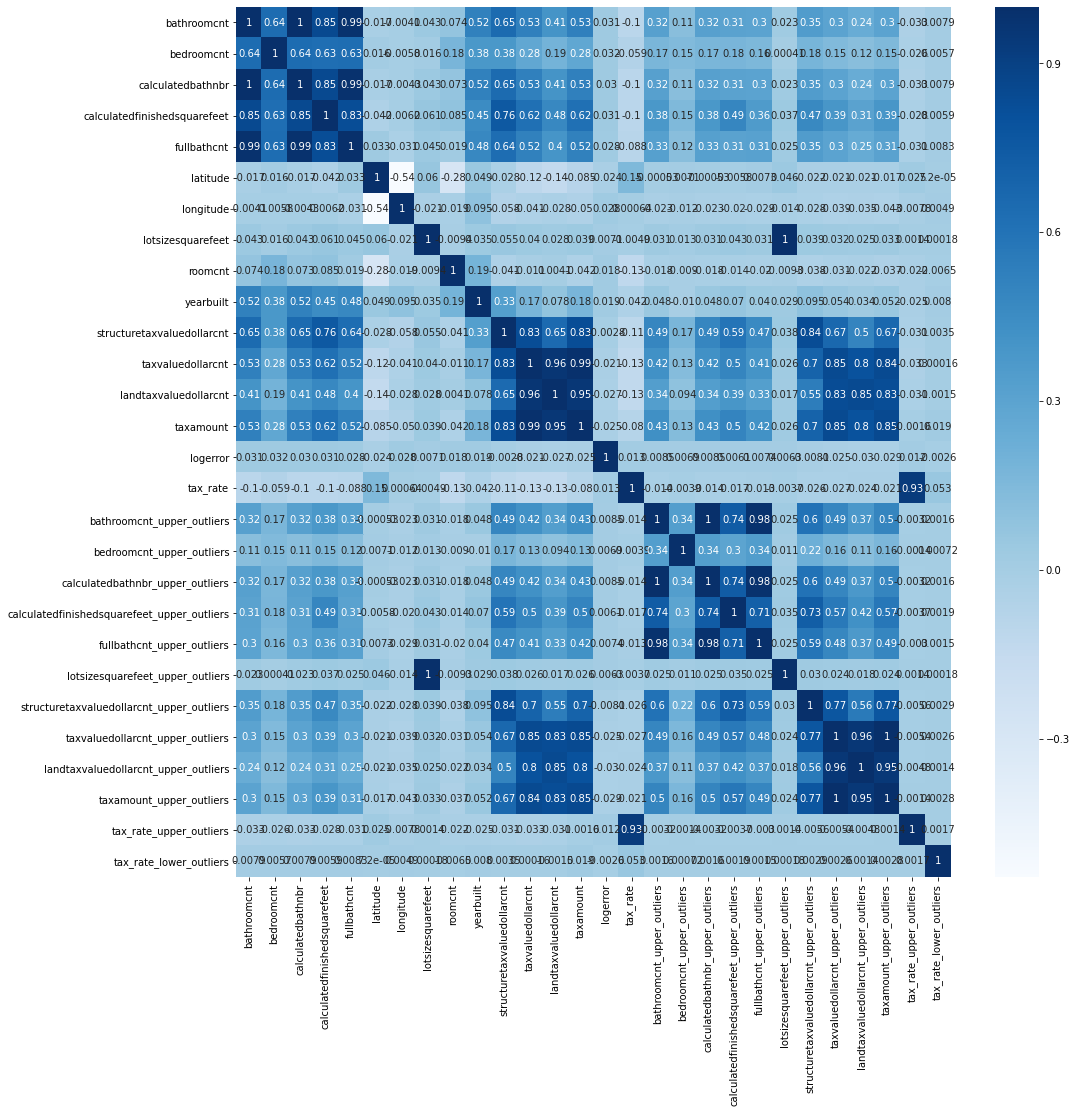

In [96]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [97]:
X = train[["logerror"]]
X.shape

(31290, 1)

In [98]:
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

In [141]:
high_drop = scoreatpercentile(X, 99.9)
low_drop = scoreatpercentile(X, .1)
low_drop, high_drop

(0.5497477820424317, 0.5954353890453924)

In [142]:
train = train[(train.logerror > low_drop) & (train.logerror < high_drop)]

In [143]:
X = train[["logerror"]]


In [144]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([2, 1, 1, ..., 1, 5, 1], dtype=int32)

In [145]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

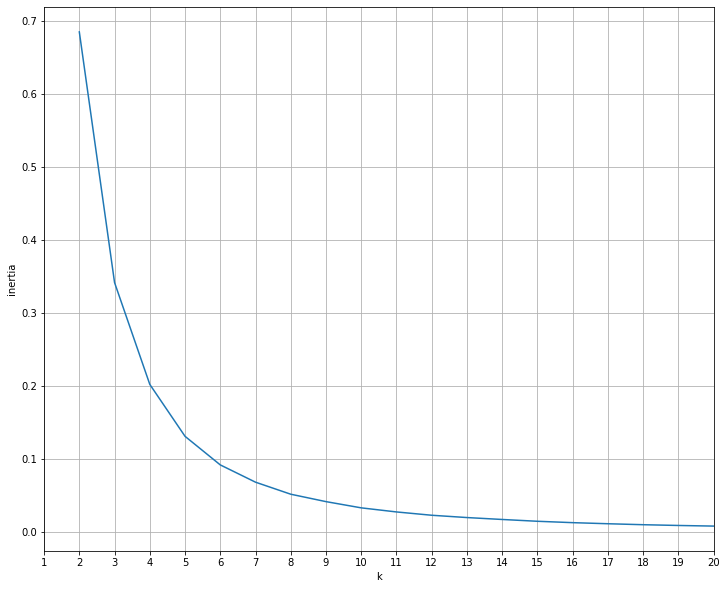

In [146]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [162]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)

In [163]:
train["cluster"]= "cluster_" + train.cluster_target.astype(str)
train.cluster.head()

33391    cluster_6
44811    cluster_4
24405    cluster_0
10440    cluster_0
46017    cluster_0
Name: cluster, dtype: object

In [164]:
kmeans.cluster_centers_

array([[0.56591535],
       [0.58061421],
       [0.56139642],
       [0.57414887],
       [0.5696517 ],
       [0.5896575 ],
       [0.55471809]])

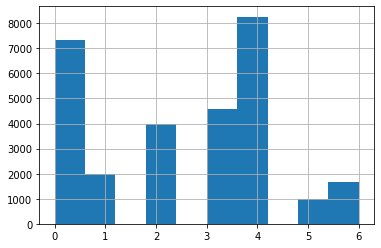

In [165]:
train.cluster_target.hist()

In [166]:
train.cluster_target.value_counts()

4    8261
0    7319
3    4595
2    3978
1    1968
6    1648
5     997
Name: cluster_target, dtype: int64

#### target variable cluster insights
- logerror clustering has huge value_counts range
- using score at percentile we can see that clusters still have huge range in size

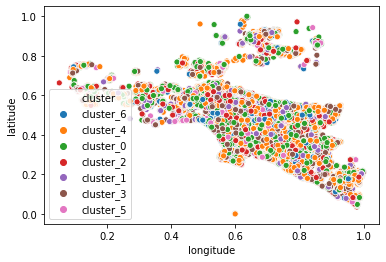

In [167]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster')

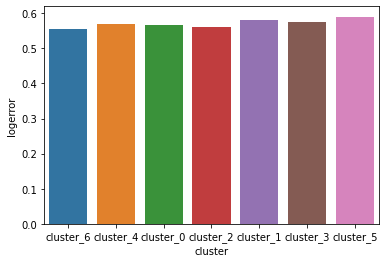

In [168]:
sns.barplot(x='cluster', y='logerror', data=train)

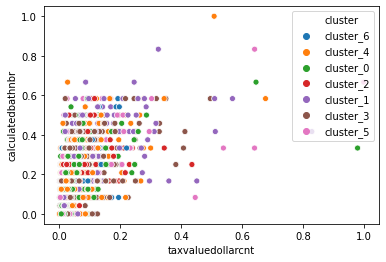

In [169]:
sns.scatterplot(x='taxvaluedollarcnt', y='calculatedbathnbr', data=train, hue='cluster')

In [254]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc',
       'county', 'tax_rate', 'bathroomcnt_upper_outliers',
       'bedroomcnt_upper_outliers', 'calculatedbathnbr_upper_outliers',
       'calculatedfinishedsquarefeet_upper_outliers',
       'fullbathcnt_upper_outliers', 'lotsizesquarefeet_upper_outliers',
       'structuretaxvaluedollarcnt_upper_outliers',
       'taxvaluedollarcnt_upper_outliers',
       'landtaxvaluedollarcnt_upper_outliers', 'taxamount

# Feature engineering:
- tax rate
- buildingqualitytypeid    
- landtaxvaluecount
- lotsizesquarefeet
- calculatedbathnbr
~~roomcnt~~

## Yard_size

In [239]:
train['yard_size'] = train.lotsizesquarefeet - train.calculatedfinishedsquarefeet

In [312]:
X = train[['yard_size']]

In [313]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [314]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([4, 0, 1, ..., 2, 2, 0], dtype=int32)

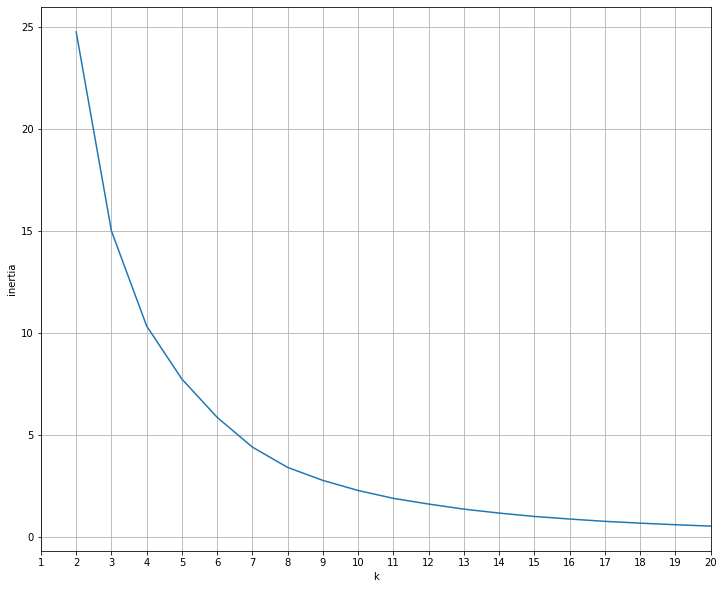

In [315]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [316]:
len(X), train.shape[0]

(28766, 28766)

In [317]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_yard"] = kmeans.predict(X)

In [318]:
train["cluster_yard"]= "cluster_" + train.cluster_target.astype(str)
train.cluster.head()

33391    cluster_1
44811    cluster_0
24405    cluster_2
10440    cluster_1
46017    cluster_2
Name: cluster, dtype: object

In [319]:
kmeans.cluster_centers_

array([[-0.0986979 ],
       [-0.04327975],
       [-0.20022445],
       [-0.13832787],
       [-0.34972855],
       [ 0.92170639],
       [-0.0683214 ]])

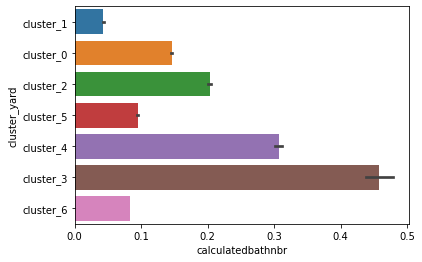

In [320]:
sns.barplot(x='calculatedbathnbr', y='cluster_yard', data=train)

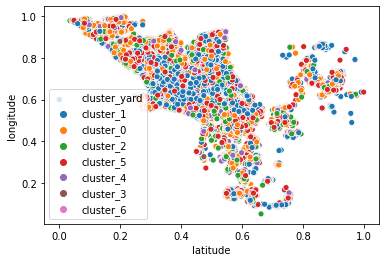

In [321]:
sns.scatterplot(x='latitude', y='longitude', data=train, hue='cluster_yard')

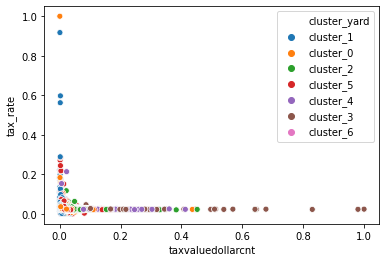

In [330]:
sns.scatterplot(x='taxvaluedollarcnt', y='tax_rate', data=train, hue='cluster_yard')

## Price per square foot
- Can't do the calculation on scaled data because 0 is in scaling for calculatedfinishedsquarefeet

In [ ]:
df['price_per_sq_ft'] = df.taxvaluedollarcnt / df.calculatedfinishedsquarefeet

In [322]:
X = df[['price_per_sq_ft']]

In [323]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [324]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([0, 2, 0, ..., 1, 2, 2], dtype=int32)

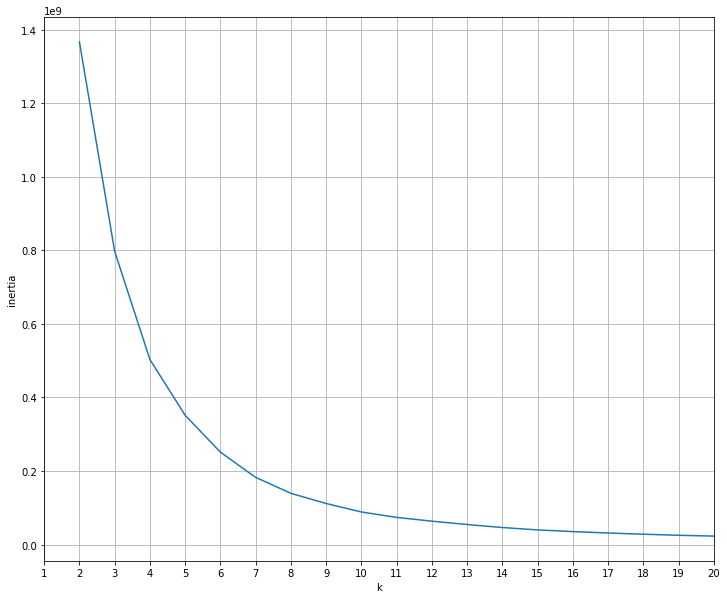

In [325]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [336]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
df["cluster_feature"] = kmeans.predict(X)

In [338]:
df["cluster_ppsq"]= "cluster_" + df.cluster_feature.astype(str)
df.cluster_ppsq.head()

0    cluster_6
1    cluster_6
2    cluster_3
3    cluster_4
4    cluster_6
Name: cluster_ppsq, dtype: object

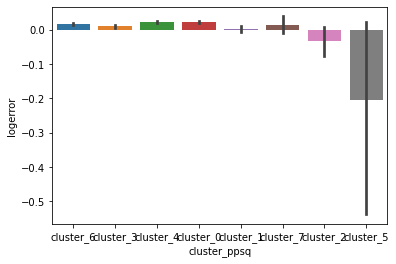

In [341]:
sns.barplot(y='logerror', x='cluster_ppsq', data=df)

In [277]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc',
       'county', 'tax_rate', 'bathroomcnt_upper_outliers',
       'bedroomcnt_upper_outliers', 'calculatedbathnbr_upper_outliers',
       'calculatedfinishedsquarefeet_upper_outliers',
       'fullbathcnt_upper_outliers', 'lotsizesquarefeet_upper_outliers',
       'structuretaxvaluedollarcnt_upper_outliers',
       'taxvaluedollarcnt_upper_outliers',
       'landtaxvaluedollarcnt_upper_outliers', 'taxamount

### Drop roomcnt as a feature
- Too many zero values
- Unsure if bathrooms count as rooms

### Drop transaction_date

In [282]:
# list_room =[]
# if train.roomcnt != 0:
#     list_room.append(train.roomcnt - train.bedroomcnt)

# list_room.max()

(df[df.roomcnt > 0].roomcnt - df[df.roomcnt > 0].bedroomcnt).describe()

count    14550.000000
mean         3.370722
std          1.052552
min         -3.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
dtype: float64

In [283]:
(df[df.roomcnt > 0].roomcnt - df[df.roomcnt > 0].bedroomcnt).nsmallest(40)

30629   -3.0
1920    -2.0
4883    -2.0
10568   -2.0
11138   -2.0
13599   -2.0
16429   -2.0
16668   -2.0
20425   -2.0
23541   -2.0
35279   -2.0
40460   -2.0
49151   -2.0
1809    -1.0
2562    -1.0
2990    -1.0
3975    -1.0
8725    -1.0
25728   -1.0
26885   -1.0
27857   -1.0
31146   -1.0
32687   -1.0
37849   -1.0
41660   -1.0
42798   -1.0
44062   -1.0
44528   -1.0
50343   -1.0
51494   -1.0
137      0.0
431      0.0
2706     0.0
2802     0.0
3180     0.0
3214     0.0
3830     0.0
4012     0.0
4553     0.0
7288     0.0
dtype: float64

In [236]:
train.roomcnt.value_counts()

0.000000    20564
0.400000     2192
0.466667     2064
0.533333     1659
0.333333     1052
0.600000      662
0.266667      263
0.666667      189
0.733333       57
0.200000       37
0.800000       17
0.133333        4
0.866667        4
0.933333        2
Name: roomcnt, dtype: int64

In [350]:
mask = (train.taxvaluedollarcnt - train.taxvaluedollarcnt_upper_outliers == 0 )
train[mask]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,tax_rate_lower_outliers,cluster_target,cluster,yard_size,cluster_yard,price_per_sq_ft
14664,0.00997353,0.0,0.111111,0.272727,0.0,0.020067,6037,0.0,0.403129,0.645335,0.000432,0100,0.00192117,12447,3101,96040,0.0,0,0.557971,0.00011,0.0,0,0.000108,0.000802,3.35945e-06,0.576977,2017-03-30,Floor/Wall,Single Family Residential,Los Angeles County,0.183531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149537,1.0,1,cluster_1,-0.019635,cluster_1,0.0


In [383]:
k = 3
outlier_columns = ['tax_rate', 'lotsizesquarefeet']
def get_thresholds(df=df, columns=outlier_columns, k=3):
    list_upper = []
    list_lower = []
    for col in outlier_columns:
        lower_25 = (df[col].quantile(.25))
        upper_75 = (df[col].quantile(.75))
        IQR = iqr(df[col])*k
        upper_threshold = upper_75 + IQR
        if df[col].min() >= 0:
            lower_threshold = max([lower_25 - IQR, 0])
        else:
            lower_threshold = lower_25 - IQR
        list_upper.append(upper_threshold)
        list_lower.append(lower_threshold)
    return list_upper, list_lower

In [442]:
list_upper, list_lower = get_thresholds()
list_upper[1]
outlier_columns

['tax_rate', 'lotsizesquarefeet']

In [451]:
def replace_outliers(df=df, outliers_columns=outlier_columns, list_upper=list_upper, list_lower=list_lower):
    for i in range(0, len(outlier_columns)):
        col = outlier_columns[i]
        rebuild_col = []
        for x in df[col]:
            if x > list_upper[i]:
                rebuild_col.append(list_upper[i])
            elif x < list_lower[i]:
                rebuild_col.append(list_upper[i])
            elif x > list_lower[i] and x < list_upper[i]:
                rebuild_col.append(x)
            else:
                rebuild_col.append(-50000000000)
        df[col] = rebuild_col
    return df  

In [456]:
df = replace_outliers(df)
df.tax_rate.max() == list_upper[0]

True

In [429]:
# for x in df.lotsizesquarefeet:
#     if x > upper_threshold:
#         df.lotsizesquarefeet = df.lotsizesquarefeet.replace(list_upper[1])
#     elif x < lower_threshold:
#         x = (list_lower[1])

In [439]:
# testing = [if x > list_upper[1] list_upper[1] for x in df.lotsizesquarefeet ]
rebuild_col = []
for x in df.lotsizesquarefeet:
    if x > list_upper[1]:
        rebuild_col.append(list_upper[1])
    else:
        rebuild_col.append(x)
df.lotsizesquarefeet = rebuild_col

52152

In [197]:
new_df = wr.get_zillow_data()

In [198]:
new_df.shape

(77580, 68)

In [217]:
list_to_drop = []
for col in new_df.columns:
    if new_df[col].isna().mean() > .80:
        list_to_drop.append(col)
new_df.drop(columns=list_to_drop, inplace=True)
new_df.shape

(77580, 41)

In [218]:
neighborhood_df = new_df[new_df.regionidneighborhood > 0]

In [219]:
neighborhood_df.isnull().mean()

id                              0.000000
parcelid                        0.000000
airconditioningtypeid           0.610189
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingqualitytypeid           0.175663
calculatedbathnbr               0.005101
calculatedfinishedsquarefeet    0.001776
finishedsquarefeet12            0.065184
fips                            0.000000
fullbathcnt                     0.005101
garagecarcnt                    0.855524
garagetotalsqft                 0.855524
heatingorsystemtypeid           0.207626
latitude                        0.000000
longitude                       0.000000
lotsizesquarefeet               0.077743
poolcnt                         0.748014
propertycountylandusecode       0.000000
propertylandusetypeid           0.000000
propertyzoningdesc              0.156551
rawcensustractandblock          0.000000
regionidcity                    0.000000
regionidcounty                  0.000000
regionidneighbor